# Backtesting with a gap 

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to do **backtesting with a gap** on both **single and multiple time series** using a **direct and recursive forecasting** strategy. We will also have **exogenous features** and an **expanding training window**. We will use the `skforecast` package to help us do this.

To obtain a robust estimate of the model's predictive capacity, a backtesting process is carried out. The process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).

**Backtesting with a gap**

There is a gap between the training period and test period.

![image](./images/backtesting_refit_gap.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_gap.gif)

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html).



## Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Single time series

## Data


A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. The data comes with two simulated exogenous variables. The data used in the examples of this document have been obtained from the magnificent book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [2]:
from skforecast.datasets import fetch_dataset

In [3]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **Pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [4]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When using the `asfreq()` method in Pandas, any gaps in the time series will be filled with `NaN` values to match the specified frequency. Therefore, it is essential to check for any missing values that may occur after this transformation.

In [5]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


Text(0.5, 1.0, 'Monthly expenditure ($AUD) on corticosteroid drugs')

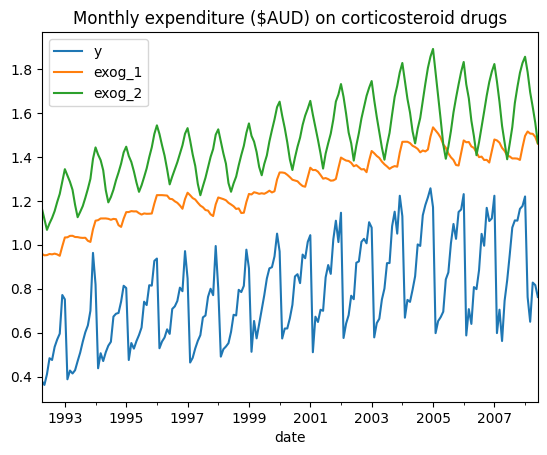

In [6]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")

## Model (direct forecasting)

In [7]:
# Single time series forecasters (direct)
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

With the `ForecasterAutoregDirect` class, a forecasting model is created and trained using a `Ridge` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [8]:
# Create forecaster

steps = 10  # Number of steps to forecast.
# This needs to include the size of the gap.
# If we want a gap of 3, and forecast 7 steps
# after the gap we need to set steps=10.

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=steps,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

## Backtesting

![image](./images/backtesting_refit_gap.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_gap.gif)


In [9]:
from skforecast.model_selection import backtesting_forecaster

Note: The arguments needed to achieve this configuration are `gap=n` and `refit=True` and `fixed_train_size=False`.

In [10]:
# Backtesting

# Initial training set size
initial_train_size = 100

# Gap between train and test
gap = 3

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    gap=gap,
    steps=steps - gap,  # This needs to be
    # the size of the
    # test set
    metric="mean_squared_error",
    refit=True,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 100
Number of observations used for backtesting: 95
    Number of folds: 14
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 3
    Last fold only includes 1 observations.

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2000-07-01 00:00:00  (n=100)
    Validation: 2000-11-01 00:00:00 -- 2001-05-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-02-01 00:00:00  (n=107)
    Validation: 2001-06-01 00:00:00 -- 2001-12-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2001-09-01 00:00:00  (n=114)
    Validation: 2002-01-01 00:00:00 -- 2002-07-01 00:00:00  (n=7)
Fold: 3
    Training:   1992-04-01 00:00:00 -- 2002-04-01 00:00:00  (n=121)
    Validation: 2002-08-01 00:00:00 -- 2003-02-01 00:00:00  (n=7)
Fold: 4
    Training:   1992-04-01 00:00:00 -- 2002-11-01 00:00:00  (n=128)


/Users/kishan_manani/.pyenv/versions/3.10.2/envs/fcst-ml/lib/python3.10/site-packages/skforecast/model_selection/model_selection.py:554: LongTrainingWarning: The forecaster will be fit 140 times (14 folds * 10 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metric (MSE): 0.012080899279330698


In [11]:
metric

0.012080899279330698

In [12]:
predictions.head()

,pred
2000-11-01,0.849762
2000-12-01,0.832619
2001-01-01,0.776272
2001-02-01,0.635655
2001-03-01,0.679222


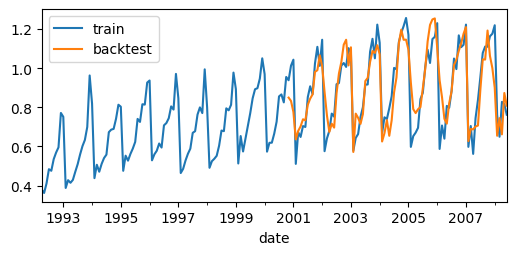

In [13]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend();

In [14]:
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.012080899279330698


# Multiple independent time series

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data), specifically `train.csv`. This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

## Data

In [15]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` requires that each time series is a column in the dataframe and that the index is time-like (datetime or timestamp). 

So now we process the data to get dataframes in the required format.

In [16]:
# Data preprocessing

selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0


In [17]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_68862/762125342.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


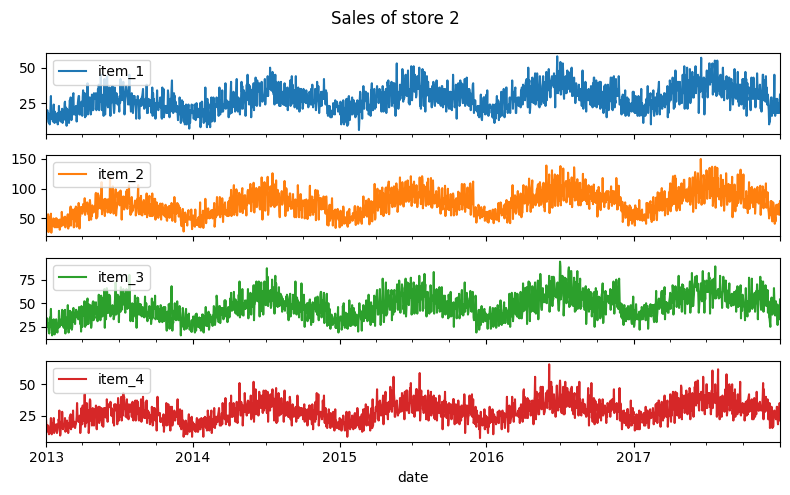

In [18]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout();

Let's add the day of the week to use as an exogenous feature.

In [19]:
data["day_of_week"] = data.index.weekday

## Model (Independent time series and recursive forecasting)

In [20]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple independent series forecasting (recursive)
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiSeriesCustom import (
    ForecasterAutoregMultiSeriesCustom,
)

In [21]:
# Define parameters of a lightgbm
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 10,
    "random_state": 8520,
    "verbose": -1,
}
forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(**params_lgbm),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

## Backtesting

![image](./images/backtesting_refit_gap.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_gap.gif)


In [22]:
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

Note: The arguments needed to achieve this configuration are `gap=n` and `refit=True` and `fixed_train_size=False`.

In [23]:
# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Initial training set size
initial_train_size = 1700

# Gap between training and test set
gap = 3

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    gap=gap,
    steps=steps,
    metric=["mean_absolute_error", "mean_squared_error"],
    fixed_train_size=False,
    refit=True,
    verbose=True,
    show_progress=True,
    allow_incomplete_fold=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1700
Number of observations used for backtesting: 126
    Number of folds: 18
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 3
    Last fold only includes 4 observations.

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-08-27 00:00:00  (n=1700)
    Validation: 2017-08-31 00:00:00 -- 2017-09-06 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-09-03 00:00:00  (n=1707)
    Validation: 2017-09-07 00:00:00 -- 2017-09-13 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-01 00:00:00 -- 2017-09-10 00:00:00  (n=1714)
    Validation: 2017-09-14 00:00:00 -- 2017-09-20 00:00:00  (n=7)
Fold: 3
    Training:   2013-01-01 00:00:00 -- 2017-09-17 00:00:00  (n=1721)
    Validation: 2017-09-21 00:00:00 -- 2017-09-27 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-01 00:00:00 -- 2017-09-24 00:00:00  (n

  0%|          | 0/18 [00:00<?, ?it/s]

In [24]:
metric

,levels,mean_absolute_error,mean_squared_error
0,item_1,5.572429,50.483505
1,item_2,10.454550,182.726251
2,item_3,7.489477,90.464336
3,item_4,4.888323,40.747240
4,item_5,4.192215,31.332977
5,item_6,10.720672,175.292268
6,item_7,10.482747,172.930732
7,item_8,12.852960,256.573537
8,item_9,10.269845,147.831008
9,item_10,12.998681,248.340199


In [25]:
predictions

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2017-08-31,32.843970,86.059964,51.753181,33.008111,24.732237,90.008467,87.299082,113.171079,78.256824,107.547356,...,31.915702,56.927072,75.769864,44.785247,119.162673,84.151139,33.800280,75.937135,43.624754,99.490622
2017-09-01,33.574538,90.218601,55.144201,34.330232,27.179598,90.418090,88.385620,118.451836,79.952852,111.621441,...,33.816660,57.379530,76.932604,45.425287,124.594482,88.131017,32.070269,77.293331,42.180571,101.888369
2017-09-02,34.606370,89.203880,57.873713,34.856960,27.652880,93.089450,91.445942,121.725415,80.971910,115.364616,...,34.566171,57.385574,79.651933,46.159798,125.982134,91.257768,33.906362,80.035088,44.705458,101.111404
2017-09-03,35.334384,91.681041,58.111471,35.719407,27.834507,92.343731,92.966644,122.548773,82.007407,116.802299,...,34.944404,59.051452,80.850952,47.233846,128.506063,92.916416,35.564717,81.297896,46.662470,103.302591
2017-09-04,30.596055,71.091044,47.089799,26.917424,21.947143,73.408061,76.714869,100.587078,67.159750,88.997805,...,28.051367,48.071341,66.670389,37.017313,98.637851,73.972278,30.011796,66.081156,35.446582,81.562823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,25.907411,70.869282,45.483830,26.772297,22.805937,73.886817,70.412385,99.051048,64.219863,89.838558,...,27.005537,44.022708,62.393498,36.178909,99.907988,73.767212,26.428267,62.878564,35.226056,76.813739
2017-12-28,24.141517,70.774904,48.761505,24.664350,22.219182,75.824379,69.691812,94.695662,59.844341,89.525107,...,25.359924,43.438693,61.818255,36.099065,98.585769,71.886828,25.462178,63.667727,34.524225,79.232726
2017-12-29,27.844690,75.119500,46.347826,27.043174,22.860804,72.944487,71.956356,97.247863,61.863452,93.384871,...,23.824104,44.609837,63.405271,39.840540,105.053855,70.440439,28.493568,67.460626,36.885345,84.546668
2017-12-30,27.786505,74.465616,51.585382,28.914916,24.306273,73.801406,75.651785,98.871070,66.067742,99.380877,...,27.592758,47.779361,67.358982,39.119695,104.892955,77.569377,29.522316,69.491968,37.372462,85.959640


Let's compute the mean absolute error over all the data points.

In [26]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_true=data[target_cols].loc[predictions.index],
    y_pred=predictions,
)

9.604760101317394

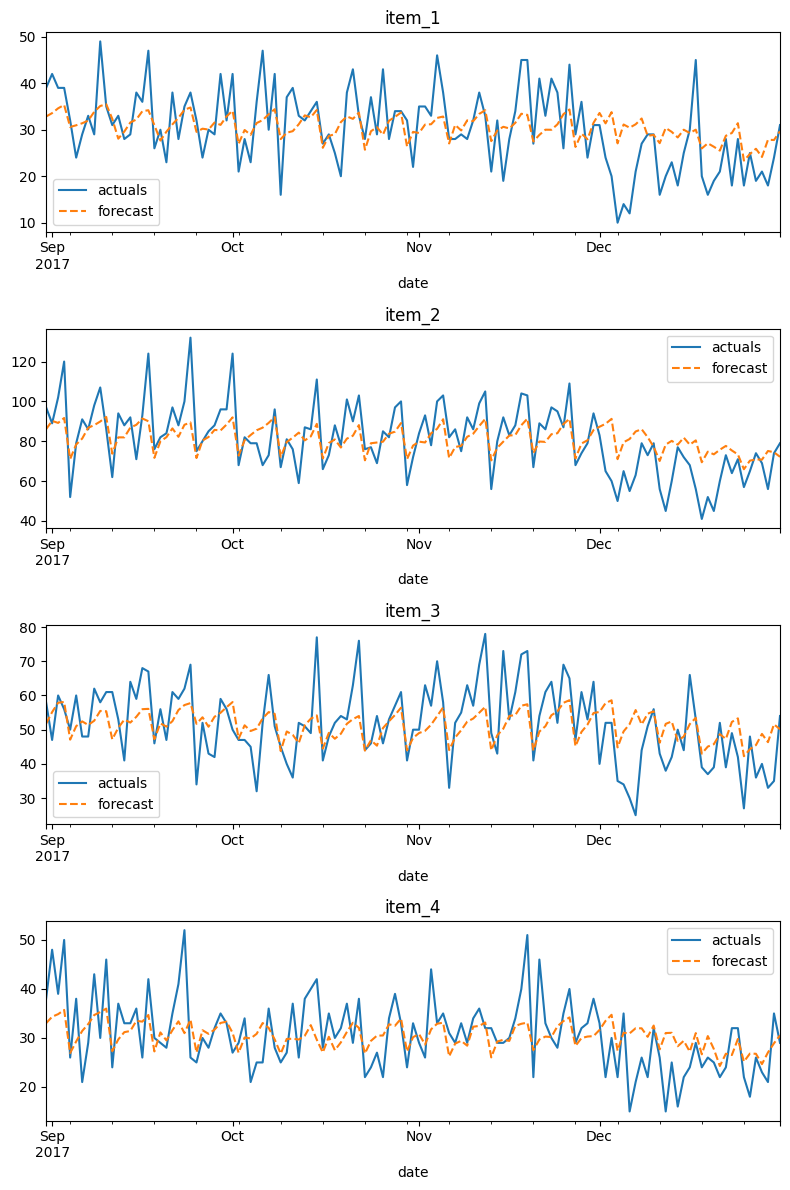

In [27]:
# Plot predictions
num_timeseries = 4
fig, axs = plt.subplots(nrows=num_timeseries, figsize=(8, 3*num_timeseries))
for i in range(4):
    timeseries = data.columns[i]
    data.iloc[-len(predictions):, i].plot(
        legend=True,
        label="actuals",
        ax=axs[i],
    )
    predictions.iloc[:, i].plot(
        legend=True,
        label="forecast",
        linestyle="--",
        ax=axs[i],
    )
    axs[i].set_title(f"{timeseries}")
    fig.tight_layout();